
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split as sksplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [3]:
def train_test_split(df):
    return sksplit(df, test_size=0.2, random_state=42)
#Split the data into a training set, and test set 
def accuracy(pred, actual):
    return np.sum(np.equal(pred, actual))/len(pred)
# Calculate the accuracy percentage of the predicted values

In [5]:
X = pd.read_pickle('transformed_data.pkl')
y = pd.read_pickle('transformed_y.pkl')
X_train, X_val = train_test_split(X)
Y_train = y[X_train.index]
Y_val = y[X_val.index]

<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods.


## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

In [8]:
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1.0).fit(X_train, Y_train)
training_accuracy = accuracy(log_model.predict(X_train), Y_train)
val_accuracy = accuracy(log_model.predict(X_val), Y_val)
print(training_accuracy, val_accuracy)

0.40439932318104904 0.4155405405405405


In [9]:
log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=1)
selector = RFECV(log_model, step=1, cv=5).fit(X, y)
rank=selector.ranking_

In [10]:
pens=np.linspace(0.1,5.1,20)
fets=range(1, max(rank)+1)
val_acc=[[0 for i in range(0, len(pens))] for j in range(0, len(fets))]

for i in range(0,len(fets)):
    n=fets[i]
    X_r=X[X.columns[rank<=n]]
    for j in range(0,len(pens)):
        log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=pens[j])
        val_acc[i][j] = np.mean(cross_val_score(log_model, X_r, y, cv=5))

In [81]:
val_mat=np.matrix(val_acc)
a,b=np.unravel_index(val_mat.argmax(), val_mat.shape)
val_mat[a,b]

0.3741267450053647

In [12]:
n_opt=fets[a]
log_pen=pens[b]

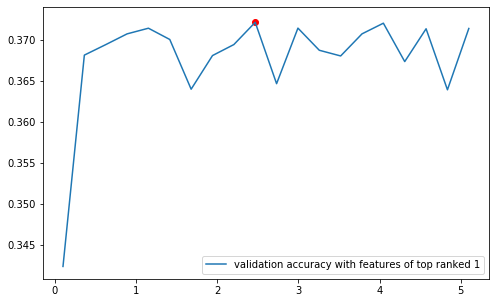

In [13]:
plt.figure(figsize=(8,5))
for i in range(0,len(fets)):
    n=fets[i]
    plt.plot(pens, val_acc[i], label='validation accuracy with features of top ranked '+str(n))
plt.scatter(pens[b], val_mat[a,b], color='r')
plt.legend();

In [14]:
columns=X.columns[rank<=n_opt]
X_train_log=X_train[columns]
X_val_log=X_val[columns]

log_model = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen).fit(X_train_log, Y_train)

training_accuracy = accuracy(log_model.predict(X_train_log), Y_train)
val_accuracy = accuracy(log_model.predict(X_val_log), Y_val)
print(training_accuracy, val_accuracy)

0.4137055837563452 0.40202702702702703


Based on the result of EDA, next we will train logistic classifier on two types of samples, one has image size lower than 300000, and the other has image size larger or equal to 300000, and see if it can provide us a better result.

In [85]:
log_model_small = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)
log_model_large = LogisticRegression(multi_class='ovr', penalty='l1', C=log_pen)
errors = []

X_train_small=X_train_log[X_train_log['size']<300000]
Y_train_small=Y_train[X_train_log['size']<300000]
X_val_small=X_val_log[X_val_log['size']<300000]
Y_val_small=Y_val[X_val_log['size']<300000]

X_train_large=X_train_log[X_train_log['size']>=300000]
Y_train_large=Y_train[X_train_log['size']>=300000]
X_val_large=X_val_log[X_val_log['size']>=300000]
Y_val_large=Y_val[X_val_log['size']>=300000]


training_accuracy_small = accuracy(log_model_small.fit(X_train_small, Y_train_small).predict(X_train_small), Y_train_small)
val_accuracy_small = accuracy(log_model_small.predict(X_val_small), Y_val_small)
print(training_accuracy_small, val_accuracy_small)

training_accuracy_large = accuracy(log_model_large.fit(X_train_large, Y_train_large).predict(X_train_large), Y_train_large)
val_accuracy_large = accuracy(log_model_large.predict(X_val_large), Y_val_large)
print(training_accuracy_large, val_accuracy_large)

print("average validation error:")
print((val_accuracy_small*len(X_train_small)+val_accuracy_large*len(X_train_large))/len(X_train_log))

0.50625 0.4880952380952381
0.35793357933579334 0.3515625
average validation error:
0.4254888556522439


## K-nearest Neighbors

In [86]:
from sklearn.neighbors import KNeighborsClassifier

In [87]:
n_neighbors = 15
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, Y_train)
training_accuracy = accuracy(knn_model.predict(X_train), Y_train)
print(training_accuracy)

0.2817258883248731


In [88]:
val_accuracy = accuracy(knn_model.predict(X_val), Y_val)
print(val_accuracy)

0.20270270270270271


## Classification Tree

In [89]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth=None).fit(X_train, Y_train)
training_accuracy = accuracy(dtree_model.predict(X_train), Y_train)
print(training_accuracy)

1.0


In [90]:
val_accuracy = accuracy(dtree_model.predict(X_val), Y_val)
print(val_accuracy)

0.31756756756756754


## Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
forest_model = RandomForestClassifier(n_estimators=100, 
                                    bootstrap = True, 
                                    max_features = 'sqrt', 
                                    max_depth=None)
selector = RFECV(forest_model, step=1, cv=5).fit(X_r, y)
rank=selector.ranking_

In [93]:
val_acc=[]
deps=range(1,25)
fets=range(1, max(rank)+1)
val_acc=[[0 for i in range(0, len(deps))] for j in range(0, len(fets))]

for i in range(0,len(fets)):
    n=fets[i]
    X_r=X[X.columns[rank<=n]]
    for j in range(0,len(deps)):
        forest_model = RandomForestClassifier(n_estimators=100, 
                                                      bootstrap = True, 
                                                      max_features = 'sqrt', 
                                                      max_depth=deps[j])

        val_acc[i][j] = np.mean(cross_val_score(forest_model, X_r, y, cv=5))

In [99]:
val_mat = np.matrix(val_acc)
a,b=np.unravel_index(val_mat.argmax(), val_mat.shape)
val_mat[a,b]

0.3672499599385973

In [100]:
n_opt=fets[a]
rf_dep=deps[b]

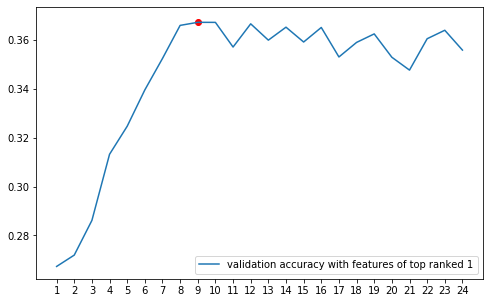

In [101]:
plt.figure(figsize=(8,5))
#plt.plot(deps, train_acc, label='train accuracy')
for i in range(0,len(fets)):
    n=fets[i]
    plt.plot(deps, val_acc[i], label='validation accuracy with features of top ranked '+str(n))
plt.scatter(rf_dep, val_mat[a,b], color='r')
plt.xticks(deps)
plt.legend();

In [102]:
columns=X.columns[rank<=n_opt]
X_train_rf=X_train[columns]
X_val_rf=X_val[columns]

forest_model = RandomForestClassifier(n_estimators=100, 
                                      bootstrap = True, 
                                      max_features = 'sqrt', 
                                      max_depth=rf_dep).fit(X_train_rf, Y_train)
training_accuracy = accuracy(forest_model.predict(X_train_rf), Y_train)
val_accuracy = accuracy(forest_model.predict(X_val_rf), Y_val)
print(training_accuracy, val_accuracy)

0.7681895093062606 0.38513513513513514


## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(C=1.0, tol=1e-3, kernel='linear').fit(X_train, Y_train)
training_accuracy = accuracy(svc_model.predict(X_train), Y_train)
print(training_accuracy)

In [ ]:
val_accuracy = accuracy(svc_model.predict(X_val), Y_val)
print(val_accuracy)

## Test on test data

In [16]:
test_data=pd.read_pickle("transformed_data_test.pkl")
X_test=test_data

In [17]:
X_test

,size,red_avg,aspectratio,green_avg,blue_avg,red_std,green_std,blue_std,grey_std,colorful,num_blob,red_rank,green_rank,blue_rank
Id,,,,,,,,,,,,,,
0,1620000,105.980433,0.666667,106.905494,105.590887,67.205121,65.316848,63.113690,0.256376,171.341564,88,1.000000,1.000000,1.000000
1,91821,144.792694,0.526971,147.593426,133.982324,79.839361,77.287288,76.796918,0.304696,159.033671,16,1.000000,1.000000,1.000000
2,312006,133.637670,1.171141,123.831301,118.584796,68.821922,72.801423,82.262728,0.284262,175.422400,10,1.000000,1.000000,1.000000
3,70308,96.696962,0.656085,83.622675,85.577701,61.854443,52.434449,48.460702,0.212077,147.802648,2,1.000000,1.000000,1.000000
4,244650,23.246266,1.502146,40.598455,46.887554,25.818695,28.859210,34.166635,0.111580,93.570925,1,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1229580,82.298175,0.624691,88.592117,138.559137,33.266301,34.144022,46.221502,0.135341,73.953556,25,1.000000,1.000000,1.000000
712,490032,101.633914,0.658635,128.388609,163.542010,67.142158,70.383417,65.551384,0.266364,88.947355,10,0.929878,0.929878,0.929878
713,185115,96.093250,0.749129,126.238344,162.929860,53.152277,59.381154,72.718032,0.229114,82.100547,6,1.000000,1.000000,1.000000


In [18]:
columns=X_test.columns[rank<=n_opt]
X_test_log=X_test[columns]

X_test_small=X_test_log[X_test_log['size']<300000]
#Y_test_small=Y_test[X_test_log['size']<300000]

X_test_large=X_test_log[X_test_log['size']>=300000]
#Y_test_large=Y_test[X_test_log['size']>=300000]

In [20]:
y_hat_small=log_model_small.predict(X_test_small)
y_hat_small=pd.DataFrame({
    'index':X_test_small.index,
    'encoding':y_hat_small
})

y_hat_large=log_model_large.predict(X_test_large)
y_hat_large=pd.DataFrame({
    'index':X_test_large.index,
    'encoding':y_hat_large
})

In [21]:
y_hat=pd.concat([y_hat_small, y_hat_large])
y_hat=y_hat.sort_values(by='index').set_index(keys='index')
y_hat

,encoding
index,
0,19
1,12
2,5
3,12
4,3
...,...
711,11
712,11
713,6


In [27]:
y_hat.to_csv('predictions.csv', index=False, header=False)